In [2]:
import numpy as np
import util
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/Users/laurazhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
trainfile = 'data/train.csv'
header, ids, X, Y = util.fetch_data(trainfile)

seed = 23
test_size = 0.80
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Basic Classifier
with data split into training and dev sets

In [5]:
xgb = XGBClassifier(objective='binary:logistic', max_depth=10, learning_rate=0.05)
#xgb.fit(X_train, y_train)

In [11]:
# gini score for training data
print(util.gini_normalized(y_train, xgb.predict(X_train)))

0.151970485915


In [12]:
# gini score for dev data
print(util.gini_normalized(y_test, xgb.predict(X_test)))

0.00590810496614


In [16]:
xgb.fit(X, Y) # retrain with all of data
util.make_prediction(xgb, 'data/test.csv', 'predictions/xgboost.csv')

# Grid Search
with full data set and 3-fold CV

In [ ]:
params_to_try = {'max_depth': range(5, 30, 5), 'learning_rate':[0.05, 0.1, 0.2, 0.3]}
c_validator = GridSearchCV(xgb, params_to_try, scoring=util.gini_scorer, verbose=2, cv=2)
c_validator.fit(X_train, y_train)

print(util.gini_normalized(y_train, c_validator.predict(X_train)))

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] learning_rate=0.05, max_depth=5 .................................
[CV] .................. learning_rate=0.05, max_depth=5, total=  14.1s
[CV] learning_rate=0.05, max_depth=5 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV] .................. learning_rate=0.05, max_depth=5, total=  13.7s
[CV] learning_rate=0.05, max_depth=10 ................................
[CV] ................. learning_rate=0.05, max_depth=10, total=  29.6s
[CV] learning_rate=0.05, max_depth=10 ................................
[CV] ................. learning_rate=0.05, max_depth=10, total=  30.9s
[CV] learning_rate=0.05, max_depth=15 ................................
[CV] ................. learning_rate=0.05, max_depth=15, total=  49.8s
[CV] learning_rate=0.05, max_depth=15 ................................
[CV] ................. learning_rate=0.05, max_depth=15, total=  46.5s
[CV] learning_rate=0.05, max_depth=20 ................................
[CV] ................. learning_rate=0.05, max_depth=20, total=  59.4s
[CV] learning_rate=0.05, max_depth=20 ................................
[CV] ................. learning_rate=0.05, max_depth=20, total= 1.1min
[CV] learning_rate=0.05, max_depth=25 ................................
[CV] .

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def plot_gridsearch_3d(c_validator, param1, param2, param1name, param2name):
    cv_results = c_validator.cv_results_
    test_mean = cv_results['mean_test_score']
    train_mean = cv_results['mean_train_score']
    
    x = np.tile(param2, len(param1))
    y = np.repeat(param1, len(param2))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.scatter(x, y, test_mean)
    ax1.title("Grid Search Test Scores")
    ax1.xlabel(param2name)
    ax1.ylabel(param1name)
    
    ax2 = fig.add_subplot(111, projection='3d')
    ax2.scatter(x, y, train_mean)
    ax2.title("Grid Search Training Scores")
    ax2.xlabel(param2name)
    ax2.ylabel(param1name)
    fig.show()

In [26]:
def plot_gridsearch_2d(c_validator, param1, param2, param1name, param2name):
    cv_results = c_validator.cv_results_
    test_mean = cv_results['mean_test_score']
    train_mean = cv_results['mean_train_score']
    
    test_mean = np.array(test_mean).reshape(len(param2),len(param1))
    train_mean = np.array(train_mean).reshape(len(param2),len(param1))
    
    plt.subplot(121)
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(param2):
        plt.plot(param1, test_mean[idx,:], '-o', label= param2name + ': ' + str(val))
        plt.title('Grid Search Test Scores')
        plt.xlabel(param1name)
        plt.legend()

    plt.subplot(122) 
    
    for idx, val in enumerate(param2):
        plt.plot(param1, train_mean[idx,:], '-o', label= param2name + ': ' + str(val))
        plt.title('Grid Search Training Scores')
        plt.xlabel(param1name)
        plt.legend()
    
    plt.show()

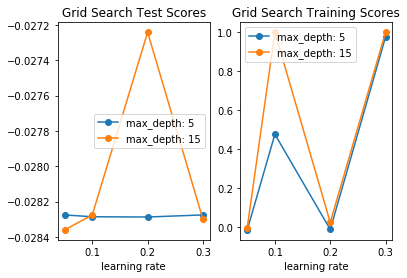

In [27]:
plot_gridsearch_2d(c_validator, params_to_try['learning_rate'], params_to_try['max_depth'], 'learning rate', 'max_depth')

In [ ]:
c_validator.best_params_